## Classical Shadows: Construction and Reconstruction

In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(666)

In [11]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ] # search for qiskit impl.

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        print(obs)
        outcomes[ns, :] = circuit_template(params, observable=obs)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

In [13]:
num_qubits = 2

# set up a two-qubit device with shots = 1 to ensure that we only get a single measurement
dev = qml.device("default.qubit", wires=num_qubits, shots=1)

# simple circuit to prepare rho
@qml.qnode(dev)
def local_qubit_rotation_circuit(params, **kwargs):
    observables = kwargs.pop("observable")
    for w in dev.wires:
        qml.RY(params[w], wires=w)

    return [qml.expval(o) for o in observables] # search for qiskit implementation


# arrays in which to collect data
elapsed_times = []
shadows = []

# collecting shadows and elapsed times
params = np.random.randn(2)
a = True
while a == True:
    num_snapshots = 10
    start = time.time()
    shadow = calculate_classical_shadow(
        local_qubit_rotation_circuit, params, num_snapshots, num_qubits
    )
    print('Shadow', shadow)
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)
    a = False



[PauliZ(wires=[0]), PauliX(wires=[1])]
[PauliY(wires=[0]), PauliX(wires=[1])]
[PauliY(wires=[0]), PauliX(wires=[1])]
[PauliY(wires=[0]), PauliY(wires=[1])]
[PauliX(wires=[0]), PauliX(wires=[1])]
[PauliX(wires=[0]), PauliX(wires=[1])]
[PauliY(wires=[0]), PauliZ(wires=[1])]
[PauliX(wires=[0]), PauliZ(wires=[1])]
[PauliZ(wires=[0]), PauliX(wires=[1])]
[PauliX(wires=[0]), PauliX(wires=[1])]
Shadow (tensor([[ 1., -1.],
        [-1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [-1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]], requires_grad=True), tensor([[2, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 2],
        [0, 2],
        [2, 0],
        [0, 0]], requires_grad=True))


In [3]:
num_qubits = 2

# set up a two-qubit device with shots = 1 to ensure that we only get a single measurement
dev = qml.device("default.qubit", wires=num_qubits, shots=1)

# simple circuit to prepare rho
@qml.qnode(dev)
def local_qubit_rotation_circuit(params, **kwargs):
    observables = kwargs.pop("observable")
    for w in dev.wires:
        qml.RY(params[w], wires=w)

    return [qml.expval(o) for o in observables] # search for qiskit implementation


# arrays in which to collect data
elapsed_times = []
shadows = []

# collecting shadows and elapsed times
params = np.random.randn(2)
for num_snapshots in [10, 100, 1000, 10000]:
    start = time.time()
    shadow = calculate_classical_shadow(
        local_qubit_rotation_circuit, params, num_snapshots, num_qubits
    )
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)

# printing out the smallest shadow as an example
print(shadows[0][0])
print(shadows[0][1])

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1.  1.]
 [-1. -1.]]
[[2 2]
 [1 2]
 [0 1]
 [2 0]
 [0 2]
 [1 0]
 [2 0]
 [1 2]
 [0 1]
 [1 1]]


In [10]:
len(shadows[1][1])

100

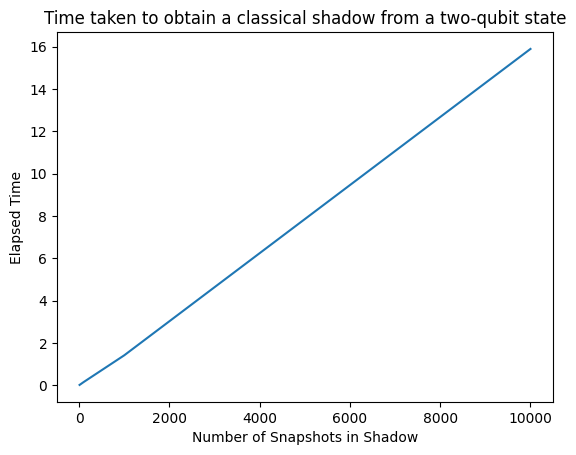

In [4]:
plt.plot([10, 100, 1000, 10000], elapsed_times)
plt.title("Time taken to obtain a classical shadow from a two-qubit state")
plt.xlabel("Number of Snapshots in Shadow")
plt.ylabel("Elapsed Time")
plt.show()

In [5]:
def snapshot_state(b_list, obs_list):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs
     a state from a single snapshot in a shadow.

    Implements Eq. (S44) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        b_list (array): The list of classical outcomes for the snapshot.
        obs_list (array): Indices for the applied Pauli measurement.

    Returns:
        Numpy array with the reconstructed snapshot.
    """
    num_qubits = len(b_list)

    # computational basis states
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])

    # local qubit unitaries
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)
    hadamard = qml.matrix(qml.Hadamard(0))
    identity = qml.matrix(qml.Identity(0))

    # undo the rotations that were added implicitly to the circuit for the Pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]

    # reconstructing the snapshot state from local Pauli measurements
    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]

        # applying Eq. (S44)
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot

In [6]:
def shadow_state_reconstruction(shadow):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.

    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.

    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots, num_qubits = shadow[0].shape

    # classical values
    b_lists, obs_lists = shadow

    # Averaging over snapshot states.
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])

    return shadow_rho / num_snapshots


## Example: Reconstructing a Bell State

In [8]:
num_qubits = 2

dev = qml.device("default.qubit", wires=num_qubits, shots=1)

# circuit to create a Bell state and measure it in
# the bases specified by the 'observable' keyword argument.
@qml.qnode(dev)
def bell_state_circuit(params, **kwargs):
    observables = kwargs.pop("observable")

    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])

    return [qml.expval(o) for o in observables]

In [9]:
# constructing a classical shadow of 1000 snapshots

num_snapshots = 1000
params = []

shadow = calculate_classical_shadow(
    bell_state_circuit, params, num_snapshots, num_qubits
)
print(shadow[0])
print(shadow[1])

[[ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 ...
 [ 1. -1.]
 [-1.  1.]
 [ 1.  1.]]
[[1 0]
 [0 1]
 [2 0]
 ...
 [1 1]
 [1 1]
 [0 2]]


### Reconstruct the Bell state

In [10]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=6))

[[ 0.50275+0.j       0.0285 -0.02325j  0.06375+0.j       0.4995 -0.00675j]
 [ 0.0285 +0.02325j -0.01925+0.j       0.027  -0.00675j -0.04425-0.018j  ]
 [ 0.06375-0.j       0.027  +0.00675j -0.05675+0.j       0.006  +0.00375j]
 [ 0.4995 +0.00675j -0.04425+0.018j    0.006  -0.00375j  0.57325+0.j     ]]


In [13]:
bell_state = np.array([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]])
bell_state

tensor([[0.5, 0. , 0. , 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0. , 0. , 0.5]], requires_grad=True)

In [15]:
# Using operator norm to measure closenenss
def operator_2_norm(R):
    """
    Calculate the operator 2-norm.

    Args:
        R (array): The operator whose norm we want to calculate.

    Returns:
        Scalar corresponding to the norm.
    """
    return np.sqrt(np.trace(R.conjugate().transpose() @ R))

# Calculating the distance between ideal and shadow states.
operator_2_norm(bell_state - shadow_state)

(0.16156422871415568+0j)

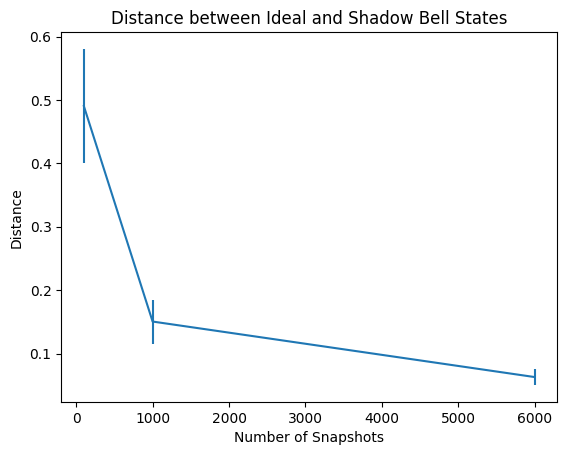

In [16]:
number_of_runs = 10
snapshots_range = [100, 1000, 6000]
distances = np.zeros((number_of_runs, len(snapshots_range)))

# run the estimation multiple times so that we can include error bars
for i in range(number_of_runs):
    for j, num_snapshots in enumerate(snapshots_range):
        shadow = calculate_classical_shadow(
            bell_state_circuit, params, num_snapshots, num_qubits
        )
        shadow_state = shadow_state_reconstruction(shadow)

        distances[i, j] = np.real(operator_2_norm(bell_state - shadow_state))

plt.errorbar(
    snapshots_range,
    np.mean(distances, axis=0),
    yerr=np.std(distances, axis=0),
)
plt.title("Distance between Ideal and Shadow Bell States")
plt.xlabel("Number of Snapshots")
plt.ylabel("Distance")
plt.show()